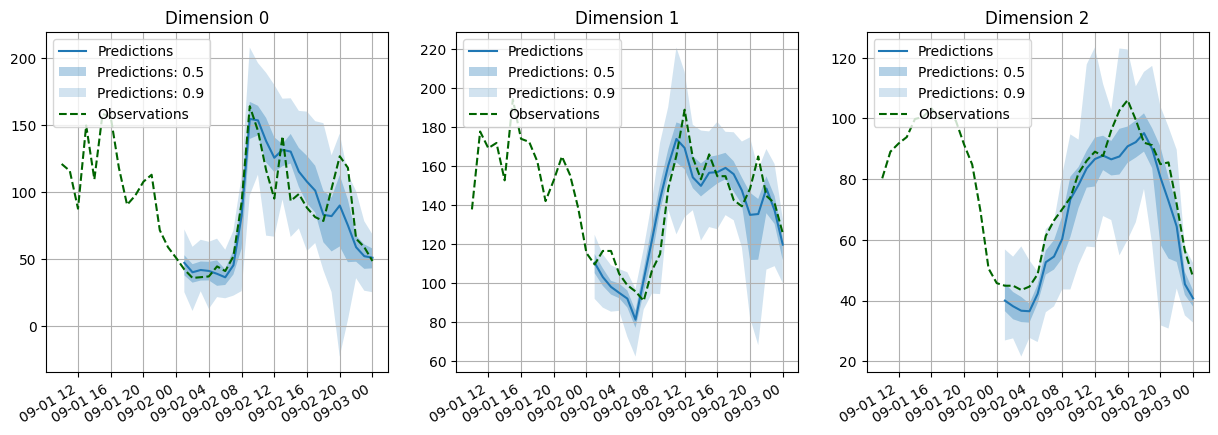

In [3]:
import os
import json
import pickle
import matplotlib.pyplot as plt

path = 'results/momentum-variational'
metrics   = os.path.join(path, 'metrics.json')
file_path = os.path.join(path, 'forecasts.pickle')

# Open the pickle file in binary read mode
with open(file_path, 'rb') as file:
    data = pickle.load(file)
    
with open(metrics, 'rb') as file:
    metrics = json.load(file)

test_id = 1
forecasts = data[0][test_id]
targets = data[1][test_id]
# print(type(targets))
# print(targets.index)

def plot_dimensions(forecasts, targets,ax, dim,title):
    forecast = forecasts.copy_dim(dim)
    forecast_start = forecast.start_date
    forecast.plot(ax=ax,name='Predictions',show_label=True)
    targets.loc[forecast_start-15:,dim].plot(ax=ax,style='--',label='Observations',color='darkgreen')
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_title(title)

def create_fig(forecasts, targets, filename):
    n_rows = 3
    fig,ax = plt.subplots(1,n_rows,figsize=(5 * n_rows, 5))
    for i in range(3):
        plot_dimensions(forecasts,targets,ax[i],i,f'Dimension {i}')
        
    fig.savefig(filename,bbox_inches='tight')


    
    
create_fig(forecasts,targets,filename=os.path.join(path,f'variational-3-dimensions.png'))